In [6]:
import nltk
import requests
import warnings
import sqlite3

# Data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot

# Financial data extraction
import yfinance as yf

# SQL Alchemy for database interaction
from sqlalchemy import create_engine, inspect
from sqlalchemy.orm import Session

from config import api_key

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [7]:
engine = create_engine('sqlite:///future_price_analysis.sqlite')
session = Session(engine)


In [12]:
inspect(engine).get_table_names()

['predicted_closing', 'stock_history']

In [9]:
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
start='2023-01-01'
end='2024-04-01'

In [33]:
# stock_data = {ticker: yf.download(ticker, start, end) for ticker in tickers}
# for ticker, df in stock_data.items():
#     df['Ticker'] = ticker

# df = pd.concat(stock_data.values())

In [34]:
# df.to_sql('stock_history', con=engine, if_exists='replace', index=True)

In [11]:
df = pd.read_sql('SELECT * FROM stock_history', engine)

ObjectNotExecutableError: Not an executable object: 'SELECT * FROM stock_history'

In [36]:
df.shape

(1866, 8)

In [37]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2023-01-03 00:00:00.000000,243.080002,245.750000,237.399994,239.580002,236.609253,25740000,MSFT
1,2023-01-04 00:00:00.000000,232.279999,232.869995,225.960007,229.100006,226.259186,50623400,MSFT
2,2023-01-05 00:00:00.000000,227.199997,227.550003,221.759995,222.309998,219.553360,39585600,MSFT
3,2023-01-06 00:00:00.000000,223.000000,225.759995,219.350006,224.929993,222.140869,43613600,MSFT
4,2023-01-09 00:00:00.000000,226.449997,231.240005,226.410004,227.119995,224.303726,27369800,MSFT


In [38]:
X = df.drop('Close',axis=1)
y = df.Close

In [39]:
X_dummies = pd.get_dummies(X,dtype=int)

In [40]:
X_train,X_test,y_train,y_test=train_test_split(X_dummies,y,random_state=42)

In [41]:
model = LinearRegression().fit(X_train,y_train)

In [42]:
model.score(X_train,y_train)

0.9999939767705

In [43]:
model.score(X_test,y_test)

0.9999900318365003

In [44]:
y[310]

420.7200012207031

In [45]:
model.predict(X_test[(X_test['Date_2024-03-28 00:00:00.000000']==1)&(X_test['Ticker_MSFT']==1)])

array([421.53842966])

In [46]:
df['Pedicted Closing'] = model.predict(pd.get_dummies(df.drop('Close',axis=1)))

In [47]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Pedicted Closing
0,2023-01-03 00:00:00.000000,243.080002,245.750000,237.399994,239.580002,236.609253,25740000,MSFT,239.143108
1,2023-01-04 00:00:00.000000,232.279999,232.869995,225.960007,229.100006,226.259186,50623400,MSFT,228.669368
2,2023-01-05 00:00:00.000000,227.199997,227.550003,221.759995,222.309998,219.553360,39585600,MSFT,222.030801
3,2023-01-06 00:00:00.000000,223.000000,225.759995,219.350006,224.929993,222.140869,43613600,MSFT,224.498400
4,2023-01-09 00:00:00.000000,226.449997,231.240005,226.410004,227.119995,224.303726,27369800,MSFT,226.828497
...,...,...,...,...,...,...,...,...,...
1861,2024-03-22 00:00:00.000000,171.759995,173.050003,170.059998,172.279999,172.046646,71106600,AAPL,172.774647
1862,2024-03-25 00:00:00.000000,170.570007,171.940002,169.449997,170.850006,170.618591,54288300,AAPL,171.235023
1863,2024-03-26 00:00:00.000000,170.000000,171.419998,169.580002,169.710007,169.480133,57388400,AAPL,169.852080
1864,2024-03-27 00:00:00.000000,170.410004,173.600006,170.110001,173.309998,173.075241,60273300,AAPL,173.306421


In [48]:
df1 = df[['Ticker','Date','Open','Close','Pedicted Closing']].copy()

In [49]:
df1.Date = df1.Date.replace('\s.*','',regex=True)

In [50]:
df1.set_index('Date',inplace=True)

In [51]:
df1.head()

,Ticker,Open,Close,Pedicted Closing
Date,,,,
2023-01-03,MSFT,243.080002,239.580002,239.143108
2023-01-04,MSFT,232.279999,229.100006,228.669368
2023-01-05,MSFT,227.199997,222.309998,222.030801
2023-01-06,MSFT,223.000000,224.929993,224.498400
2023-01-09,MSFT,226.449997,227.119995,226.828497


In [52]:
df1.to_sql('predicted_closing', engine, if_exists='replace')

1866

NameError: name 'plt' is not defined

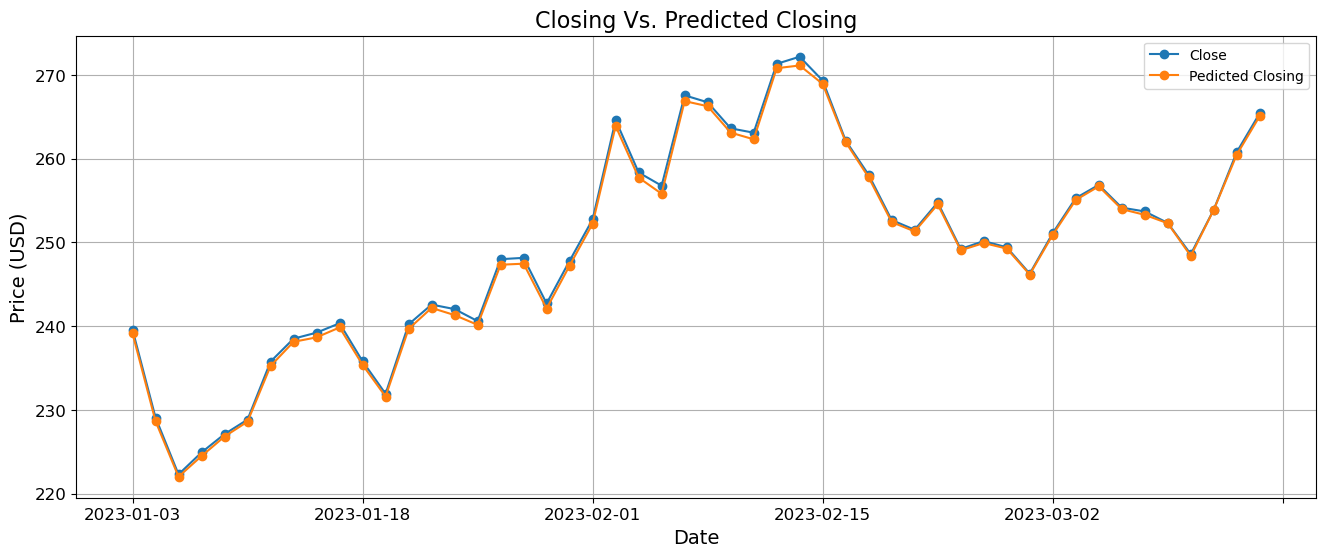

In [27]:
plot = df1[df1.Ticker=='MSFT'].reset_index()[:50].plot(
    'Date',['Close','Pedicted Closing'],
    grid=True,
    figsize=[16,6],
    marker='o',
    fontsize=12
)
plot.set_title('Closing Vs. Predicted Closing',fontsize=16)
plot.set_ylabel('Price (USD)', fontsize=14)
plot.set_xlabel('Date', fontsize=14)
plt.savefig('Closing_Vs_Predictd_Closing.png')
plt.show()

In [28]:
data = df1.reset_index()